# Introduction
This colab worksheet provides a starting point for Task 2 (the computer vision task).

# Data Loading

In [224]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5" -O face_alignment_training_images.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a" -O face_alignment_test_images.npz

--2025-05-15 12:40:45--  https://sussex.box.com/shared/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5 [following]
--2025-05-15 12:40:46--  https://sussex.box.com/public/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5 [following]
--2025-05-15 12:40:46--  https://sussex.app.box.com/public/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [225]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  print (checksum)
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('face_alignment_training_images.npz', 'affc56216e34c827f10681a14c602981c06ddeb3')
confirm_checksum('face_alignment_test_images.npz', 'e480535442512b8175ae110d2d3e507378cabbdb')



affc56216e34c827f10681a14c602981c06ddeb3  face_alignment_training_images.npz

e480535442512b8175ae110d2d3e507378cabbdb  face_alignment_test_images.npz



# Load the data

In [226]:
import numpy as np


# Load the data using np.load
data = np.load('face_alignment_training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
landmarks = data['points']

print(images.shape, landmarks.shape)

test_data = np.load('face_alignment_test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

(2811, 256, 256, 3) (2811, 5, 2)
(554, 256, 256, 3)


# Data Visualisation
Here's an example of how to display the images and their points

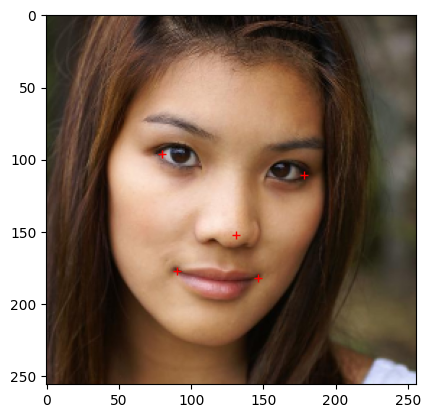

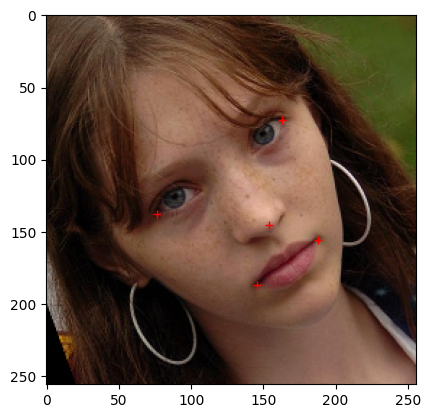

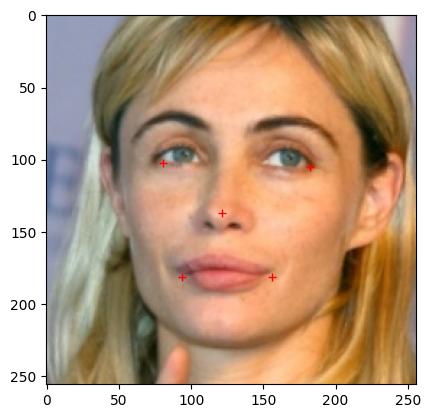

In [227]:

def visualise_landmarks(img, landmarks):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(landmarks[:, 0], landmarks[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_landmarks(images[idx, ...], landmarks[idx, ...])

In [228]:
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [229]:
# Resize images to 96x96 and convert to grayscale
# Scale landmark coordinates to match resized dimensions
def preprocessed_images(images, landmarks, target_size=(96, 96)):
    preprocessed_images = []
    preprocessed_landmarks = []
    target_w, target_h = target_size

    for img, lm in zip(images, landmarks):
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        orig_h, orig_w = img.shape[:2]
        resized_img = cv2.resize(img, (target_w, target_h))
        normalized_img = resized_img / 255.0
        scale_x = target_w / orig_w
        scale_y = target_h / orig_h
        scaled_landmarks = lm * [scale_x, scale_y]

        preprocessed_images.append(normalized_img)
        preprocessed_landmarks.append(scaled_landmarks)

    return np.array(preprocessed_images), np.array(preprocessed_landmarks)

processed_images, processed_landmarks = preprocessed_images(images, landmarks)

In [268]:
train_orig_images, val_orig_images, train_landmarks, val_landmarks = train_test_split(images, landmarks, test_size=0.2, random_state=42)
train_images, train_landmarks = preprocessed_images(train_orig_images, train_landmarks)
val_images, val_landmarks = preprocessed_images(val_orig_images, val_landmarks)


In [269]:
def mean_shape(landmarks):
    return np.mean(landmarks, axis=0)

prior_landmark_points = mean_shape(train_landmarks)

In [270]:
# Extract SIFT descriptors at 5 fixed mean shape points (128D each → 640D feature vector)
def ext_sift(images, prior_points, patch_size=5):
    sift = cv2.SIFT_create()
    features = []

    for img in images:
        keypoints = [cv2.KeyPoint(float(x), float(y), patch_size) for x, y in prior_points]
        _, descriptors = sift.compute((img * 255).astype(np.uint8), keypoints)

        if descriptors is None or descriptors.shape[0] != len(prior_points):
            descriptors = np.zeros((len(prior_points), 128))

        features.append(descriptors.flatten())

    return np.array(features)


In [271]:
# Train Ridge Regression model using extracted features to predict landmark positions
X_train = ext_sift(train_images, prior_landmark_points)
X_val = ext_sift(val_images, prior_landmark_points)

y_train = train_landmarks.reshape(len(train_landmarks), -1)
y_val = val_landmarks.reshape(len(val_landmarks), -1)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train);


# Calculating Prediction Error and exporting results

In [272]:
def euclid_dist(pred_landmarks, gt_landmarks):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_landmarks: The predicted points
  :param gt_landmarks: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_landmarks = np.reshape(pred_landmarks, (-1, 2))
  gt_landmarks = np.reshape(gt_landmarks, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_landmarks - gt_landmarks), axis=-1))


In [273]:
y_pred_prior = ridge_model.predict(X_val).reshape(-1, 5, 2)
# Rescale predicted and ground truth landmarks from 96x96 to original 256x256 resolution
scale_x = 256 / 96
scale_y = 256 / 96
rescaled_predictions = y_pred_prior * [scale_x, scale_y]
rescaled_truths = y_val.reshape(-1, 5, 2) * [scale_x, scale_y]

# Compute mean Euclidean distance between predictions and ground truth for validation images
val_error_pixels = []

for pred, truth in zip(rescaled_predictions, rescaled_truths):
    dists = euclid_dist(pred, truth)
    val_error_pixels.extend(dists)
mean_error = np.mean(val_error_pixels)
print(f"Validation Error: {mean_error:.2f} pixels")


Validation Error: 5.70 pixels


In [274]:
def visualise_prediction_with_gt(img, pred_landmarks, gt_landmarks, title=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.scatter(gt_landmarks[:, 0], gt_landmarks[:, 1], c='blue', marker='x', label='Ground Truth')
    plt.scatter(pred_landmarks[:, 0], pred_landmarks[:, 1], c='red', marker='+', label='Prediction')
    if title:
        plt.title(title)
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.show()

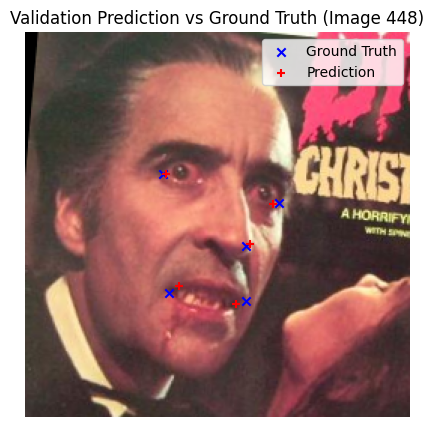

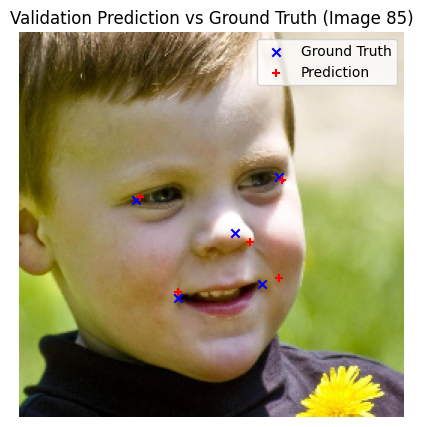

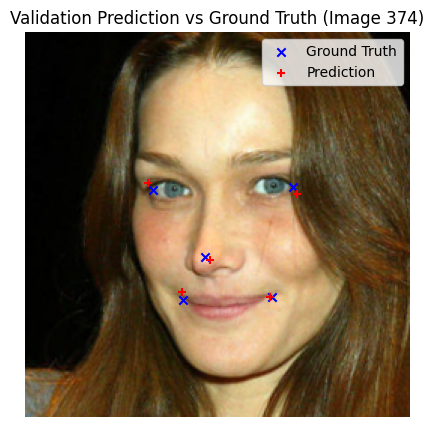

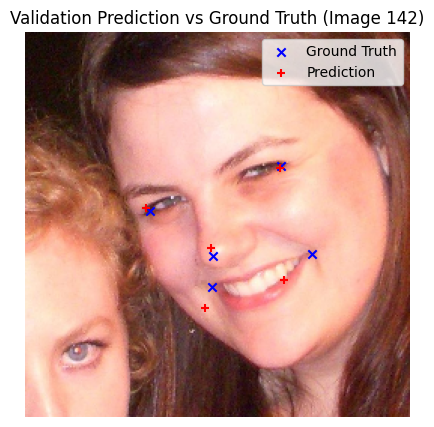

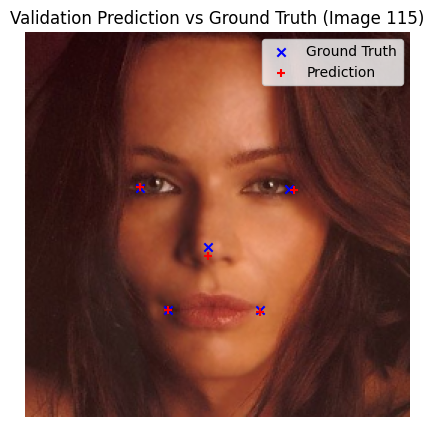

In [275]:
for i in np.random.choice(len(val_orig_images), size=5, replace=False):
    original_img = val_orig_images[i]
    scale_x = original_img.shape[1] / 96
    scale_y = original_img.shape[0] / 96

    pred_rescaled = y_pred_prior[i] * [scale_x, scale_y]
    gt_rescaled = val_landmarks[i].reshape(5, 2) * [scale_x, scale_y]

    visualise_prediction_with_gt(original_img, pred_rescaled, gt_rescaled,
                                 title=f"Validation Prediction vs Ground Truth (Image {i})")

In [276]:
processed_all_images, processed_all_landmarks = preprocessed_images(images, landmarks)
prior_landmark_points = mean_shape(train_landmarks)

In [277]:
X_full = ext_sift(processed_all_images, prior_landmark_points, patch_size=8)
y_full = processed_all_landmarks.reshape(len(processed_all_landmarks), -1)

In [278]:
final_prior_model = Ridge(alpha=1.0)
final_prior_model.fit(X_full, y_full)

Ridge()

In [279]:
test_data = np.load('face_alignment_test_images.npz', allow_pickle=True)
test_images = test_data['images']
# Preprocess (resize to 96x96, grayscale, normalize)
processed_test_images = []
for img in test_images:
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_resized = cv2.resize(img, (96, 96))
    processed_test_images.append(img_resized / 255.0)

processed_test_images = np.array(processed_test_images)

In [280]:
X_test = ext_sift(processed_test_images, prior_landmark_points, patch_size=10)
y_test_pred = final_prior_model.predict(X_test).reshape(-1, 5, 2)

In [281]:
X_full = ext_sift(processed_all_images, prior_landmark_points)
y_full = processed_all_landmarks.reshape(len(processed_all_landmarks), -1)

In [282]:
final_prior_model = Ridge(alpha=1.0)
final_prior_model.fit(X_full, y_full);

In [283]:
X_test = ext_sift(processed_test_images, prior_landmark_points)
y_test_pred = final_prior_model.predict(X_test).reshape(-1, 5, 2)

In [284]:
scale_x, scale_y = 256 / 96, 256 / 96
rescaled_test_predictions = y_test_pred * [scale_x, scale_y]

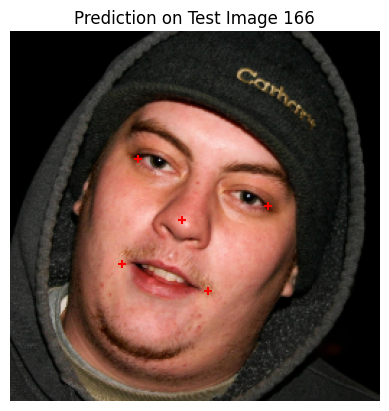

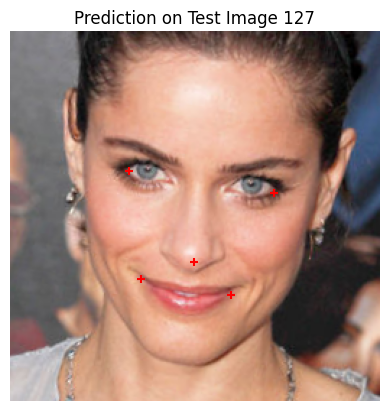

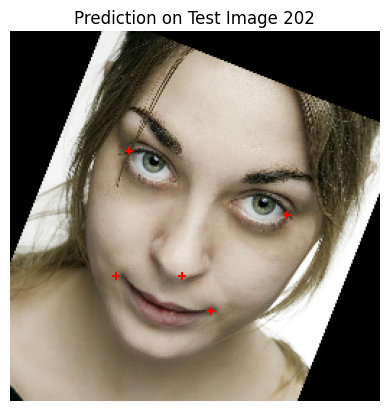

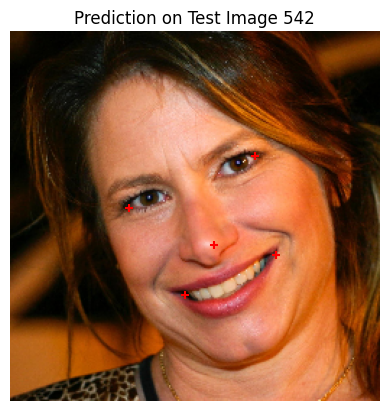

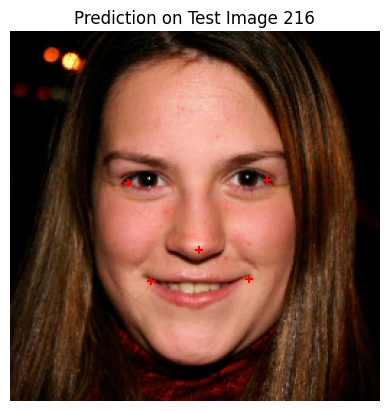

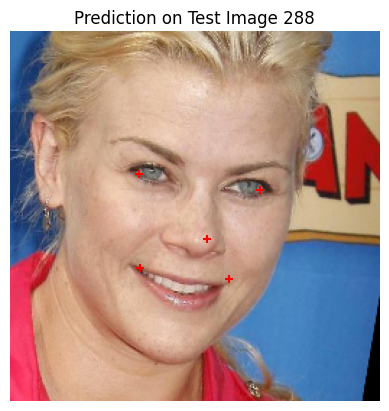

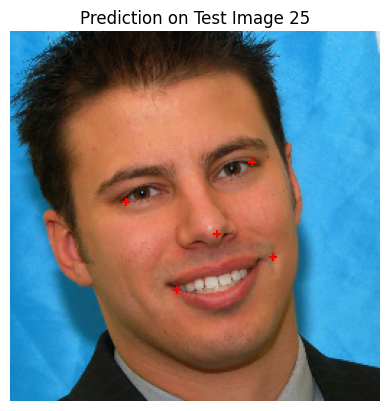

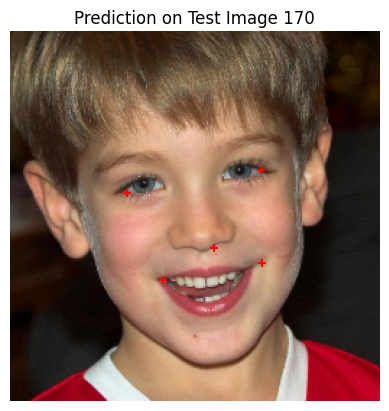

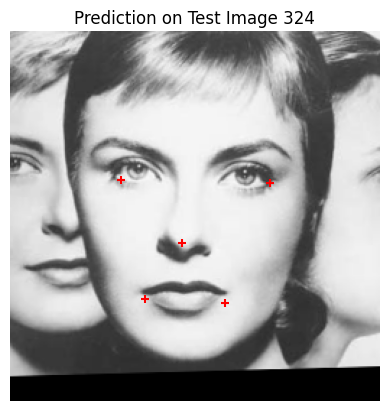

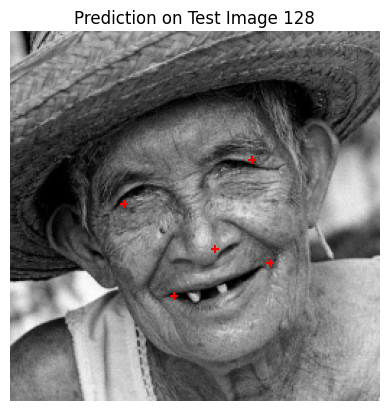

In [285]:
def visualise_prediction_test(img, predicted_landmarks, title=None):
    plt.imshow(img, cmap='gray')
    plt.scatter(predicted_landmarks[:, 0], predicted_landmarks[:, 1], c='red', marker='+')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

for i in np.random.choice(len(test_images), size=10, replace=False):
    visualise_prediction_test(test_images[i], rescaled_test_predictions[i], title=f"Prediction on Test Image {i}")

In [286]:
def save_as_csv(points, location='.'):
    assert points.shape == (554, 5, 2), f'Expected shape (554, 5, 2), got {points.shape}'
    np.savetxt(f'{location}/results_task2.csv', points.reshape(points.shape[0], -1), delimiter=',')

# Save predictions
save_as_csv(rescaled_test_predictions)

In [287]:
from google.colab import files
files.download('results_task2.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>